# NLP Classification BBC News


by: Rizki Dinata

# Download Datasets from Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download hgultekin/bbcnewsarchive

Dataset URL: https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive
License(s): copyright-authors
100% 1.81M/1.81M [00:01<00:00, 1.89MB/s]
100% 1.81M/1.81M [00:01<00:00, 1.67MB/s]


In [ ]:
!mkdir bbcnewsarchive
!unzip bbcnewsarchive.zip -d bbcnewsarchive

Archive:  bbcnewsarchive.zip
  inflating: bbcnewsarchive/bbc-news-data.csv  


# Import library necessary

In [ ]:
import pandas as pd
import numpy as np
import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#Load Datasets

In [ ]:
df = pd.read_csv('/content/bbcnewsarchive/bbc-news-data.csv', sep = '\t')
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [ ]:
df.shape

(2225, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [ ]:
df['category'].value_counts()

,count
category,
sport,511
business,510
politics,417
tech,401
entertainment,386


In [ ]:
df['text'] = df['title'].values + ' ' + df['content'].values
df = df.drop(['filename'],axis=1)
df.head()

,category,title,content,text
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,Ad sales boost Time Warner profit Quarterly p...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,Dollar gains on Greenspan speech The dollar h...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,Yukos unit buyer faces loan claim The owners ...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,High fuel prices hit BA's profits British Air...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,Pernod takeover talk lifts Domecq Shares in U...


# Data Preprocessing

In [ ]:
def preprocess_data(text):
    # lower case
    text = text.lower()

    # remove special character
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # remove number
    text = re.sub(r'\d+', '', text)

    # remove double spaces
    text = re.sub(r'\s+', ' ', text)

    # remove stopwords
    stop_word = stopwords.words('english')
    word_tokens = word_tokenize(text)
    text = ' '.join([w for w in word_tokens if w not in stop_word])

    # remove space before and after text
    text = text.strip()
    return text

In [ ]:
# apply the function preprocess data
df['text'] = df['text'].apply(preprocess_data)

## Encoding Data

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_clean = df.copy()
df_clean['category'] = le.fit_transform(df_clean['category'])
df_clean.head()

,category,title,content,text
0,0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,ad sales boost time warner profit quarterly pr...
1,0,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,dollar gains greenspan speech dollar hit highe...
2,0,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,yukos unit buyer faces loan claim owners embat...
3,0,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,high fuel prices hit bas profits british airwa...
4,0,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,pernod takeover talk lifts domecq shares uk dr...


In [ ]:
df_clean['text'][0]

'ad sales boost time warner profit quarterly profits us media giant timewarner jumped bn three months december yearearlier firm one biggest investors google benefited sales highspeed internet connections higher advert sales timewarner said fourth quarter sales rose bn bn profits buoyed oneoff gains offset profit dip warner bros less users aol time warner said friday owns searchengine google internet business aol mixed fortunes lost subscribers fourth quarter profits lower preceding three quarters however company said aols underlying profit exceptional items rose back stronger internet advertising revenues hopes increase subscribers offering online service free timewarner internet customers try sign aols existing customers highspeed broadband timewarner also restate results following probe us securities exchange commission sec close concluding time warners fourth quarter profits slightly better analysts expectations film division saw profits slump helped boxoffice flops alexander catwom

In [ ]:
df_clean['category'].value_counts()

,count
category,
3,511
0,510
2,417
4,401
1,386


## Tokenize and pad sequence

In [ ]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token='x')
tokenizer.fit_on_texts(df_clean['text'])

sequence = tokenizer.texts_to_sequences(df_clean['text'])
X = pad_sequences(sequence, maxlen=max_len)
y = df_clean['category']

In [ ]:
from sklearn.model_selection import train_test_split

# split data train+validation and data test
text_train, text_test, label_train, label_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

print(f"Train size: {len(text_train)}, Test size: {len(text_test)}")

Train size: 1780, Test size: 445


# Modelling

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax'),
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training data and use Callback to hold epoch

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nAccuracy and val_accuracy >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
num_epochs = 20
history = model.fit(text_train, label_train, epochs=num_epochs, validation_split=0.2, batch_size=32, callbacks = [callbacks], verbose=2)

Epoch 1/20
45/45 - 9s - 207ms/step - accuracy: 0.3420 - loss: 1.4972 - val_accuracy: 0.3287 - val_loss: 1.4975
Epoch 2/20
45/45 - 0s - 11ms/step - accuracy: 0.5836 - loss: 0.9226 - val_accuracy: 0.6348 - val_loss: 0.9077
Epoch 3/20
45/45 - 1s - 11ms/step - accuracy: 0.8237 - loss: 0.5077 - val_accuracy: 0.8090 - val_loss: 0.5460
Epoch 4/20
45/45 - 1s - 13ms/step - accuracy: 0.9333 - loss: 0.2250 - val_accuracy: 0.8455 - val_loss: 0.4486
Epoch 5/20
45/45 - 0s - 11ms/step - accuracy: 0.9347 - loss: 0.2314 - val_accuracy: 0.8090 - val_loss: 0.4939
Epoch 6/20

Accuracy and val_accuracy >90%!
45/45 - 1s - 14ms/step - accuracy: 0.9916 - loss: 0.0538 - val_accuracy: 0.9213 - val_loss: 0.3149


## Visualize Model Accuracy and Loss

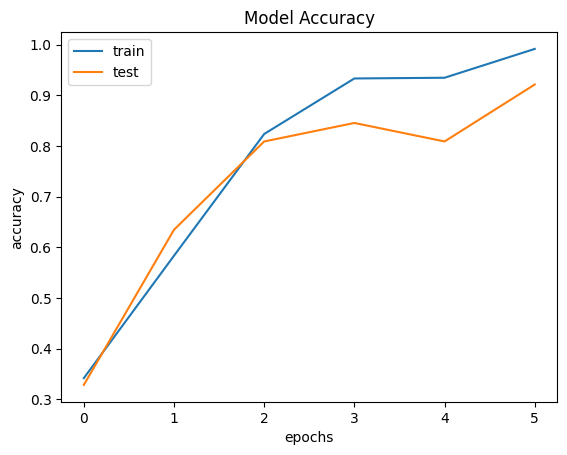

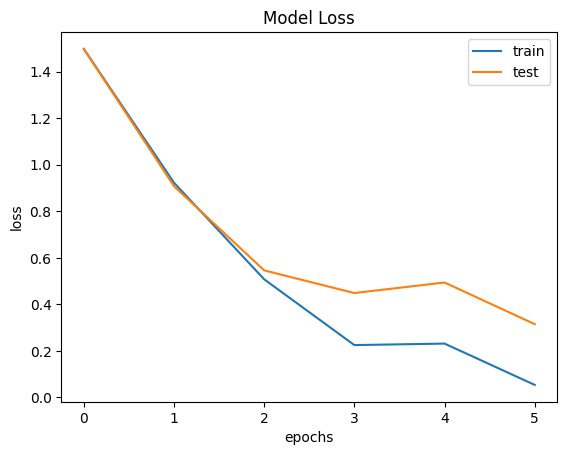

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','test'], loc='best')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','test'], loc='best')
plt.show()

# Predict to Data Test

In [ ]:
# predict data test sing neural network (np.argmax)
label_pred  = np.argmax(model.predict(text_test), axis=1)

# create classification report
from sklearn.metrics import classification_report
cf_report = classification_report(label_test, label_pred, target_names=le.classes_)
print(f"Classification Report: \n{cf_report}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Classification Report: 
               precision    recall  f1-score   support

     business       0.91      0.90      0.91       102
entertainment       0.88      0.94      0.91        77
     politics       0.97      0.87      0.92        84
        sport       0.99      0.93      0.96       102
         tech       0.85      0.96      0.90        80

     accuracy                           0.92       445
    macro avg       0.92      0.92      0.92       445
 weighted avg       0.92      0.92      0.92       445

